# Visualizing Tabular Data

# MakieCon2023

## Bogumił Kamiński

Under supervision of [Pietro Vertechi](https://github.com/piever) and [Fabian Greimel](https://github.com/greimel)

### What I planned:

Does Makie ecosystem have all features needed for visualizing tabular data?

### What I realized:

It obviously has (which is great).

So the questions are:

* How hard it is to get started with Makie?
* How hard it is to do non standard plots? (typically 90% of your plot is standard, but at the end you need to tweak it a bit)
* Should I use vanilla Makie or AlgebraOfGraphics.jl?

### Dilemmas of a typical Julia user

My journey:

* I started with PyPlot.jl, as in the past it was the only stable and mature option that had fast TTFP.
* Then I moved to Plots.jl. I fould it quite convenient and acceptable TTFP. I have written my *Julia for Data Analysis* book using Plots.jl. In corner cases I missed the fine-grained control over plotted objects.
* I avoided Makie.jl because of TTFP issue. Given Julia 1.9 release I wanted to give it a try.

### My approach

> Port all plots from *Julia for Data Analysis* from Plots.jl to Makie.jl and report the user expeience.

In [1]:
@time using DataFrames

  0.980433 seconds (1.86 M allocations: 119.933 MiB, 5.36% gc time, 0.43% compilation time)


In [2]:
@time using CSV

  0.348340 seconds (466.05 k allocations: 27.907 MiB, 7.00% gc time)


In [3]:
@time using StatsBase

  0.056483 seconds (46.10 k allocations: 3.000 MiB)


In [4]:
@time using Dates

  0.002102 seconds (817 allocations: 54.719 KiB)


In [5]:
@time using CairoMakie

 17.630266 seconds (18.89 M allocations: 1.176 GiB, 6.22% gc time, 1.22% compilation time: 34% of which was recompilation)


In [6]:
@time using AlgebraOfGraphics

  4.609028 seconds (5.67 M allocations: 330.825 MiB, 5.40% gc time)


1. I fully understood the meaning of https://docs.makie.org/stable/#installation_and_import only after some experimentation.
2. It would be easier if some simpler instruction were given (maybe in the what-if form).
3. I often need to do some quick-and-dirty plotting as a support in analysis process. Over 10 seconds of load time is still on the borderline of being prohibitive.

# Chapter 1

### Comparing code size and execution speed of C, Python, Java, and Julia for 10 selected computational problems

In [7]:
bench_data = """
problem,language,time,size
n-body,C,2.13,1633
mandelbrot,C,1.3,1135
spectral norm,C,0.41,1197
fannkuch-redux,C,7.58,910
fasta,C,0.78,1463
k-nucleotide,C,3.96,1506
binary-trees,C,1.58,809
reverse-complement,C,0.41,1965
pidigits,C,0.56,1090
regex-redux,C,0.8,1397
n-body,Java,6.77,1489
mandelbrot,Java,4.1,796
spectral norm,Java,1.55,756
fannkuch-redux,Java,10.48,1282
fasta,Java,1.2,2543
k-nucleotide,Java,4.83,1812
binary-trees,Java,2.51,835
reverse-complement,Java,1.57,2183
pidigits,Java,0.79,764
regex-redux,Java,5.34,929
n-body,Python,541.34,1196
mandelbrot,Python,177.35,688
spectral norm,Python,112.97,407
fannkuch-redux,Python,341.45,950
fasta,Python,36.9,1947
k-nucleotide,Python,46.31,1967
binary-trees,Python,44.7,660
reverse-complement,Python,6.62,814
pidigits,Python,1.16,567
regex-redux,Python,1.34,1403
n-body,Julia,4.21,1111
mandelbrot,Julia,1.42,619
spectral norm,Julia,1.11,429
fannkuch-redux,Julia,7.83,1067
fasta,Julia,1.13,1082
k-nucleotide,Julia,4.94,951
binary-trees,Julia,7.28,634
reverse-complement,Julia,1.44,522
pidigits,Julia,0.97,506
regex-redux,Julia,1.74,759
""";

In [8]:
@time bench_df = CSV.read(IOBuffer(bench_data), DataFrame)

  6.569535 seconds (5.16 M allocations: 335.753 MiB, 5.10% gc time, 99.85% compilation time: 26% of which was recompilation)


Row,problem,language,time,size
,String31,String7,Float64,Int64
1,n-body,C,2.13,1633
2,mandelbrot,C,1.3,1135
3,spectral norm,C,0.41,1197
4,fannkuch-redux,C,7.58,910
5,fasta,C,0.78,1463
6,k-nucleotide,C,3.96,1506
7,binary-trees,C,1.58,809
8,reverse-complement,C,0.41,1965
9,pidigits,C,0.56,1090


 20.081817 seconds (18.69 M allocations: 1.163 GiB, 4.88% gc time, 99.11% compilation time: 10% of which was recompilation)


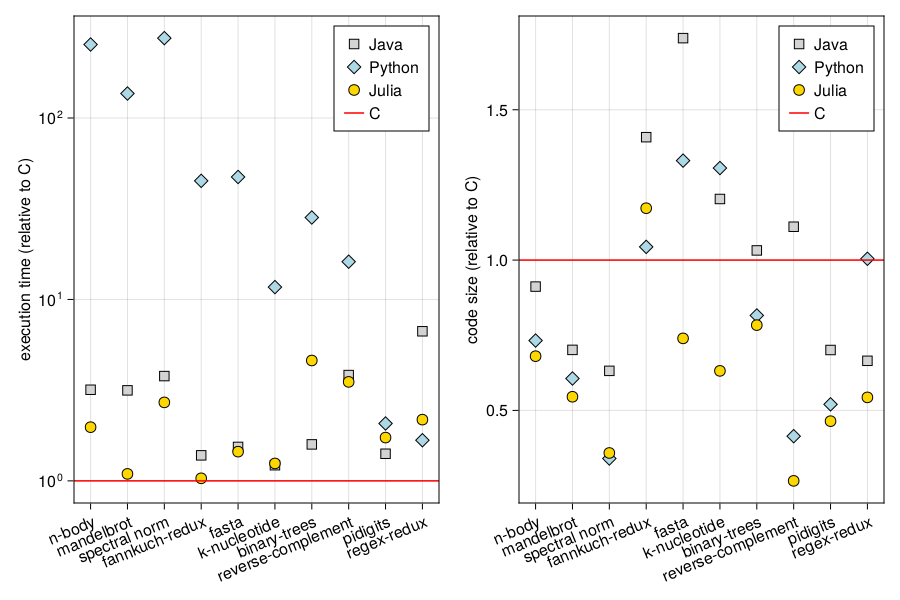

In [9]:
@time begin
    fig = Figure(resolution = (900, 600))

    for (idx, var, ylabel, yscale) in ((1, :time, "execution time (relative to C)", log10),
                                       (2, :size, "code size (relative to C)", identity))
        plot_df = unstack(bench_df, :problem, :language, var)
        plot_df[!, Not(:problem)] ./= plot_df.C
        ax = Axis(fig[1, idx]; 
                  ylabel=ylabel, yscale = yscale, xticks = (axes(plot_df, 1), plot_df.problem), xticklabelrotation=pi/8)
        scatter!(ax, axes(plot_df, 1), plot_df.Java;
                 color="lightgray", marker=:rect, strokewidth=1, markersize=15, label="Java")
        scatter!(ax, axes(plot_df, 1), plot_df.Python;
                 color="lightblue", marker=:diamond, strokewidth=1, markersize=15, label="Python")
        scatter!(ax, axes(plot_df, 1), plot_df.Julia;
                 color="gold", marker=:circle, strokewidth=1, markersize=15, label="Julia")
        hlines!(ax, 1.0; color="red", label="C")
        axislegend(ax)
    end

    fig
end

 16.768321 seconds (15.43 M allocations: 987.838 MiB, 5.20% gc time, 98.99% compilation time: 1% of which was recompilation)


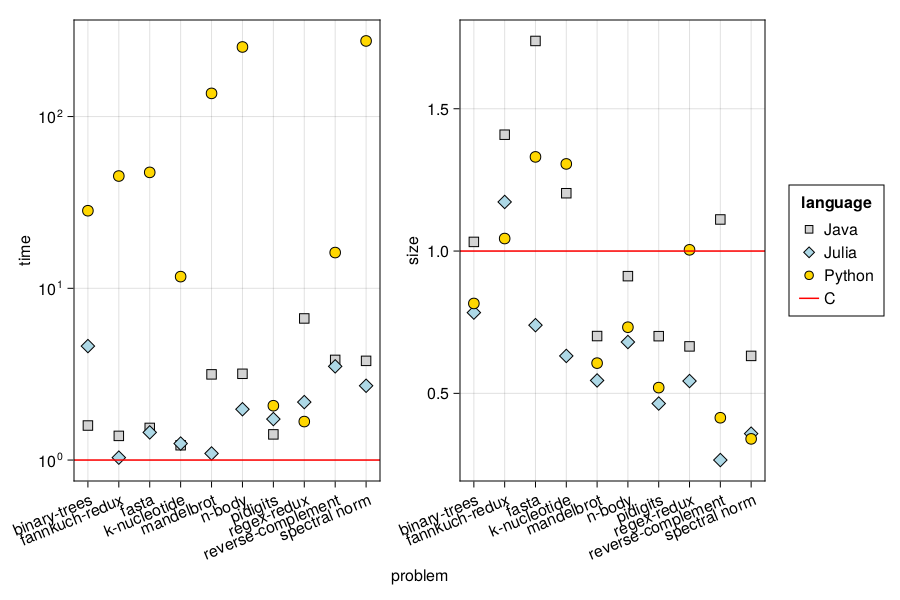

In [10]:
aog_df = combine(groupby(bench_df, :problem)) do sdf
    time = sdf.time / sdf.time[1]
    size = sdf.size / sdf.size[1]
    DataFrame(language=sdf.language, time=time, size=size)[2:end, :]
end

@time begin
    fig = Figure(resolution = (900, 600))
    aog_plt = data(aog_df) *
              mapping(:problem, [:time, :size];
                      marker=:language, color=:language, col = dims(1) => renamer(["", ""])) *
              visual(Scatter; markersize=15, strokewidth=1)
    grid = draw!(fig, aog_plt,
                 axis=(; xticklabelrotation=pi/8),
                 palettes=(; marker=[:rect, :diamond, :circle], color=["lightgray", "lightblue", "gold"]))
    hlines!(grid[1].axis, 1.0; color="red")
    hlines!(grid[2].axis, 1.0; color="red")
    grid[1].axis.yscale = log10
    lg = AlgebraOfGraphics.compute_legend(grid)
    push!(lg[1][1], [LineElement(color="red")])
    push!(lg[2][1], "C")
    Legend(fig[1, end+1], lg...)
    lg[1][1][1][1].markerstrokewidth[] = 1
    fig
end

1. I could replicate the plot exactly as I wanted it. I considered the plot to be non-trivial and I managed to just do it without a problem using Makie.jl.
2. I was not really clear how I could build this plot using AlgebraOfGraphics.jl (maybe I would be able to do it but it was conceptually much harder to me than working with Makie.jl primitives).

> It turns out that it was not trivial.

3. The `Figure`-`Axis`-plot layering was quite intuitive to me and I liked it. The only issue is that there is more to be learned (you need to know which aspects of the plot are controlled in which layer which was not always obvious).
4. It was, in particular, initially not fully obvious that mutating and non-mutating functions accept different arguments. I settled to use only mutating versions.
5. It would be super useful if for each function there were a reference with all arguments it accepts and all values they can take (I know it might be hard, but it would be quite nice to have it).
6. Time to plot is again on a border line of being prohibitively slow.

# Chapter 4

### The plot of the four data sets from Anscombe's quartet

  0.432075 seconds (368.06 k allocations: 23.849 MiB, 9.30% gc time, 87.18% compilation time: 44% of which was recompilation)


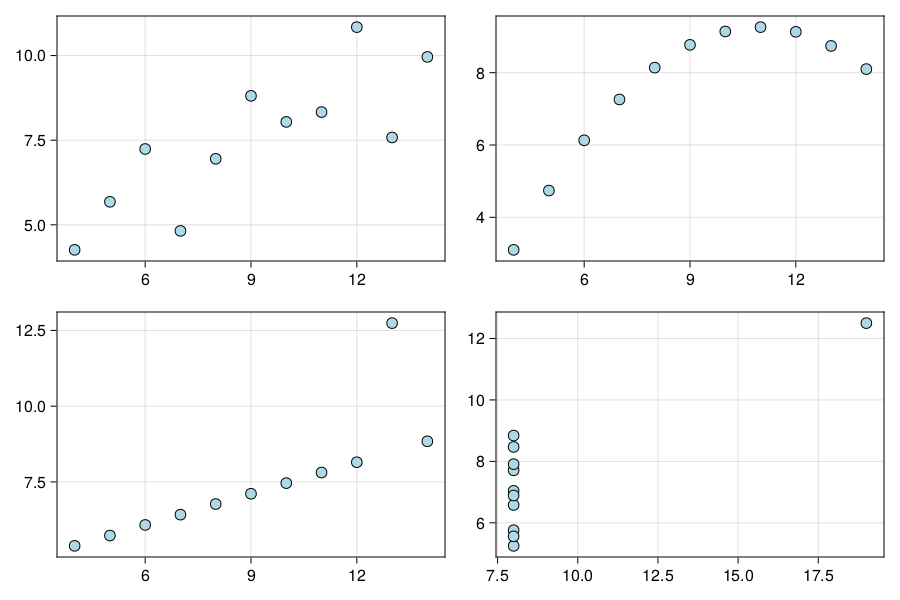

In [11]:
aq = [10.0   8.04  10.0  9.14  10.0   7.46   8.0   6.58
       8.0   6.95   8.0  8.14   8.0   6.77   8.0   5.76
      13.0   7.58  13.0  8.74  13.0  12.74   8.0   7.71
       9.0   8.81   9.0  8.77   9.0   7.11   8.0   8.84
      11.0   8.33  11.0  9.26  11.0   7.81   8.0   8.47
      14.0   9.96  14.0  8.1   14.0   8.84   8.0   7.04
       6.0   7.24   6.0  6.13   6.0   6.08   8.0   5.25
       4.0   4.26   4.0  3.1    4.0   5.39  19.0  12.50
      12.0  10.84  12.0  9.13  12.0   8.15   8.0   5.56
       7.0   4.82   7.0  7.26   7.0   6.42   8.0   7.91
       5.0   5.68   5.0  4.74   5.0   5.73   8.0   6.89];

@time begin
    fig = Figure(resolution = (900, 600))
    scatter!(Axis(fig[1, 1]), aq[:, 1], aq[:, 2]; color="lightblue", strokewidth=1, markersize=15)
    scatter!(Axis(fig[1, 2]), aq[:, 3], aq[:, 4]; color="lightblue", strokewidth=1, markersize=15)
    scatter!(Axis(fig[2, 1]), aq[:, 5], aq[:, 6]; color="lightblue", strokewidth=1, markersize=15)
    scatter!(Axis(fig[2, 2]), aq[:, 7], aq[:, 8]; color="lightblue", strokewidth=1, markersize=15)
    fig
end

  3.593768 seconds (2.77 M allocations: 181.016 MiB, 5.01% gc time, 95.59% compilation time)


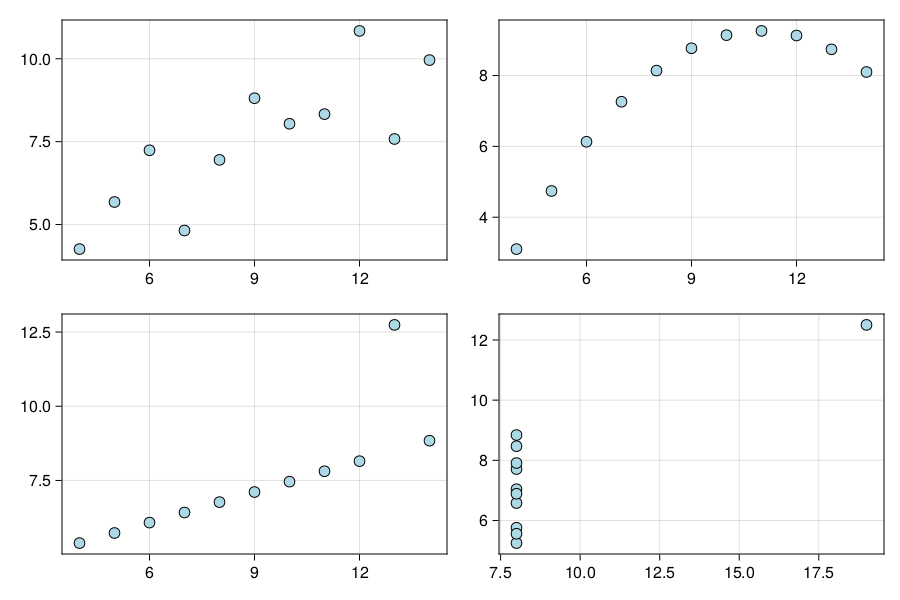

In [12]:
x = [aq[:, i] for i in 1:2:7]
y = [aq[:, i] for i in 2:2:8]
@time begin
    plt = mapping(x, y, layout=1:4 => renamer(fill("", 4))) *
          visual(color=:lightblue, strokewidth=1, markersize=15)
    draw(plt, facet=(; linkxaxes=false, linkyaxes=false), figure=(; resolution=(900, 600)))
end

1. The second plotting time is fast enough.
2. I could probably be smarter with the code, but doing copy-paste and minor tweaking was easy - which is good.
3. AlgebraOfGraphics.jl solution was smooth, but not trivial.

# Chapter 5

### Scatterplot with changing point color

  2.250905 seconds (2.77 M allocations: 172.046 MiB, 8.66% gc time, 99.29% compilation time: 8% of which was recompilation)


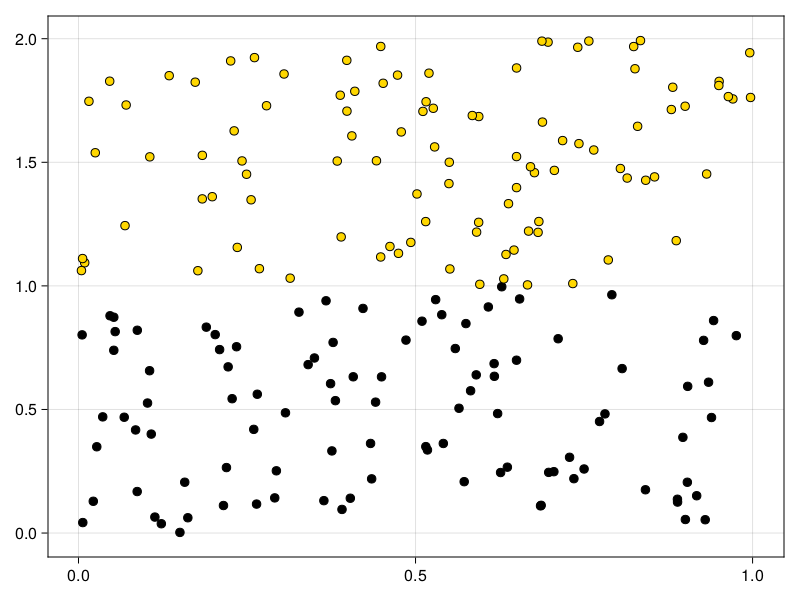

In [13]:
mat = rand(200, 2)
mat[101:end, 2] .+= 1

@time scatter(mat; color=[fill("black", 100); fill("gold", 100)], strokewidth=1)

1. Plotting time is OK again.
2. Getting two colors of the points was intuitive (I did not check manual for this), which is good.

# Chapter 6

### Line plot

  0.907355 seconds (615.85 k allocations: 41.711 MiB, 4.11% gc time, 98.34% compilation time)


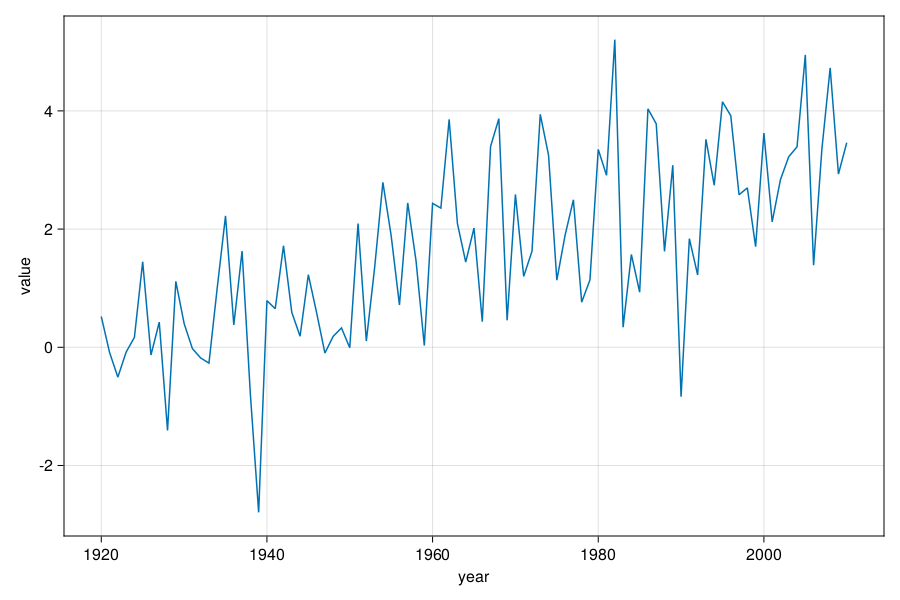

In [14]:
yr = 1920:2010
value = randn(length(yr)) + (yr .- minimum(yr)) / 25

@time begin
    fig = Figure(resolution = (900, 600))
    ax = Axis(fig[1, 1]; xlabel="year", ylabel="value")
    lines!(ax, yr, value)
    fig
end

I was able to make this plot without looking in the manual at this point.

# Chapter 7

### Plot with missing data

  2.656711 seconds (1.82 M allocations: 123.921 MiB, 4.61% gc time, 98.55% compilation time)


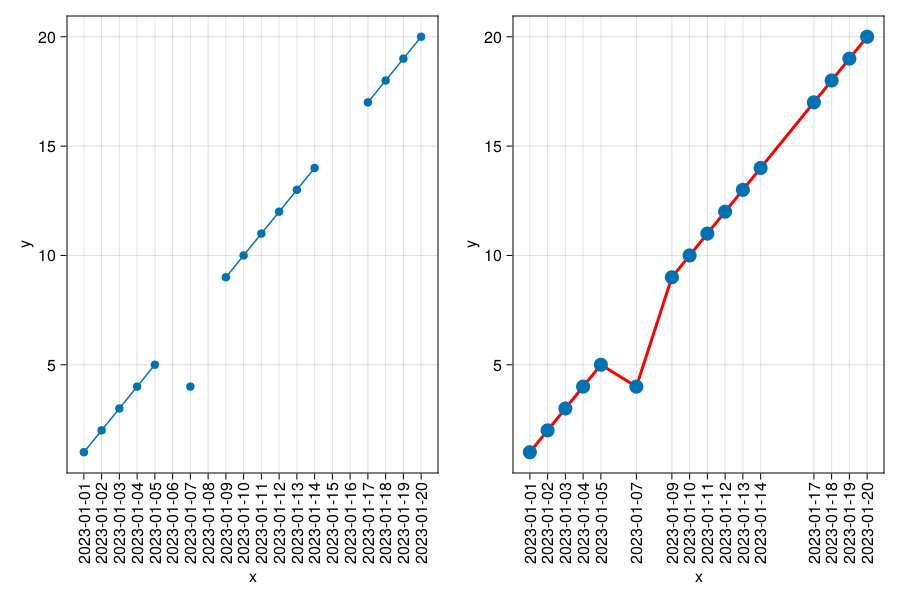

In [15]:
idx = 1:20
x = Date.(2023, 1, idx)
y = [1:5; missing; 4; missing; 9:14; missing; missing; 17:20]

@time begin
    fig = Figure(resolution = (900, 600))
    ax = Axis(fig[1, 1]; xlabel="x", ylabel="y", xticks=(idx, string.(x)), xticklabelrotation=pi/2)
    lines!(ax, idx, y)
    scatter!(ax, idx, y)

    i = .!ismissing.(y)
    idxi = idx[i]
    xi = x[i]
    yi = y[i]
    ax = Axis(fig[1, 2]; xlabel="x", ylabel="y", xticks=(idxi, string.(xi)), xticklabelrotation=pi/2)
    lines!(ax, idxi, yi, linewidth=3, color="red")
    scatter!(ax, idxi, yi, markersize=20)

    fig
end

1. Handling of missing values was as expected.
2. Ploting time was a bit long. I would expect it to be faster after doing so many plots in this session.
3. If one wants to use AlgebraOfGraphics.jl then it is easiest to put the plots into grid created in Makie.jl.

# Chapter 9

### Histograms

 11.888865 seconds (17.52 M allocations: 1.042 GiB, 8.03% gc time, 99.29% compilation time: <1% of which was recompilation)


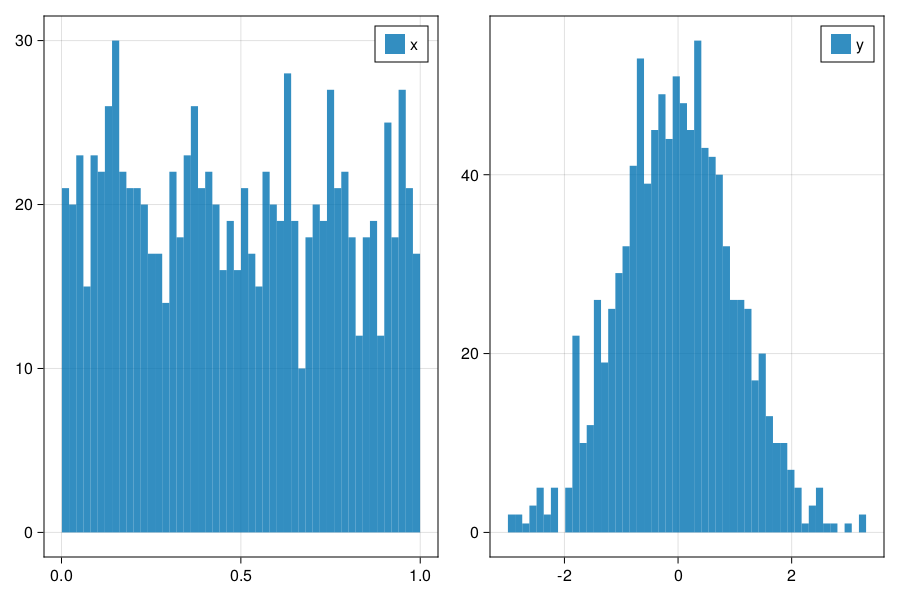

In [16]:
@time begin
    fig = Figure(resolution = (900, 600))
    hist!(Axis(fig[1, 1]), rand(1000); bins=50, label="x")
    axislegend()
    hist!(Axis(fig[1, 2]), randn(1000); bins=50, label="y")
    axislegend()
    fig
end

1. Definition of plots went smooth again.
2. Plotting time still seems long.

# Chapter 10

### Heatmap

 15.901724 seconds (16.08 M allocations: 1016.466 MiB, 7.46% gc time, 99.41% compilation time: <1% of which was recompilation)


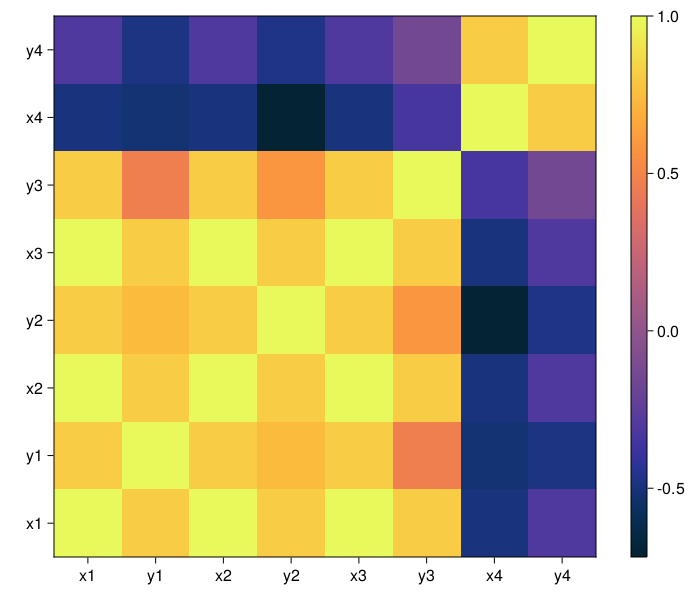

In [17]:
varnames = vec(string.(["x", "y"], [1 2 3 4]))

@time begin
    fig = Figure(resolution = (700, 600))
    hm = heatmap!(Axis(fig[1, 1],
                  xticks = (1:8, varnames),
                  yticks = (1:8, varnames),
                  aspect = 1),
                  pairwise(cor, eachcol(aq)),
                  colormap=:thermal)
    Colorbar(fig[:, end+1], hm)
    fig
end

  4.623295 seconds (3.75 M allocations: 248.545 MiB, 4.31% gc time, 97.33% compilation time)


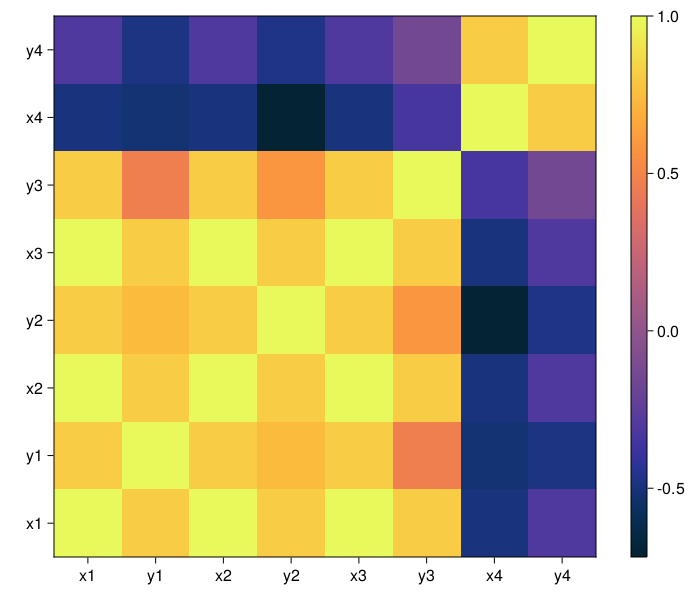

In [18]:
x = [1:8]
y = [1:8]
z = [pairwise(cor, eachcol(aq))]
@time begin
    plt = mapping(x, y, z) * visual(Heatmap, colormap=:thermal)
    draw(plt, axis=(; aspect=1, xticks = (1:8, varnames), yticks = (1:8, varnames)), figure=(; resolution = (700, 600)))
end

1. I was able to better control creation of the heatmap than in Plots.jl.
2. I had a bit hard time finding a reference for `:thermal` colormap.
3. Plotting time is unfortunately still long.
4. AlgebraOfGraphics.jl solution worked, but was not trivial.

### annotations

  2.240630 seconds (2.60 M allocations: 168.304 MiB, 7.58% gc time, 98.94% compilation time)


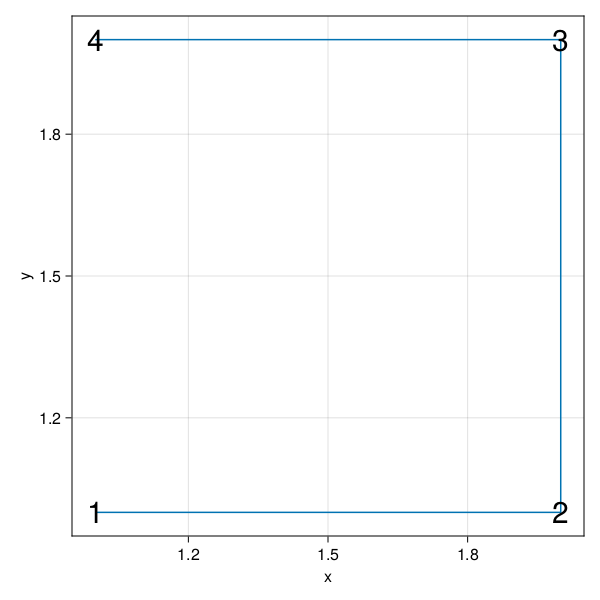

In [19]:
x = [1, 2, 2, 1]
y = [1, 1, 2, 2]

@time begin
    fig = Figure(resolution = (600, 600))
    ax = Axis(fig[1, 1]; xlabel="x", ylabel="y")
    lines!(ax, x, y)
    text!(ax, string.(1:4), position=tuple.(x, y), align=(:center, :center), fontsize=30)
    fig
end

1. Control ver text annotations is easier than in Plots.jl.
2. This time plotting time is acceptable.

# Chapter 12

### Complex scatterplot

In [20]:
include("data.jl")
describe(gh_data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,deg_ml,19.1992,0.0,9.0,1620.0,0,Float64
2,deg_web,98.0314,0.0,48.0,8194.0,0,Float64
3,frac,0.740227,0.0,1.0,1.0,0,Float64


  1.855778 seconds (2.01 M allocations: 128.101 MiB, 6.60% gc time, 96.96% compilation time)


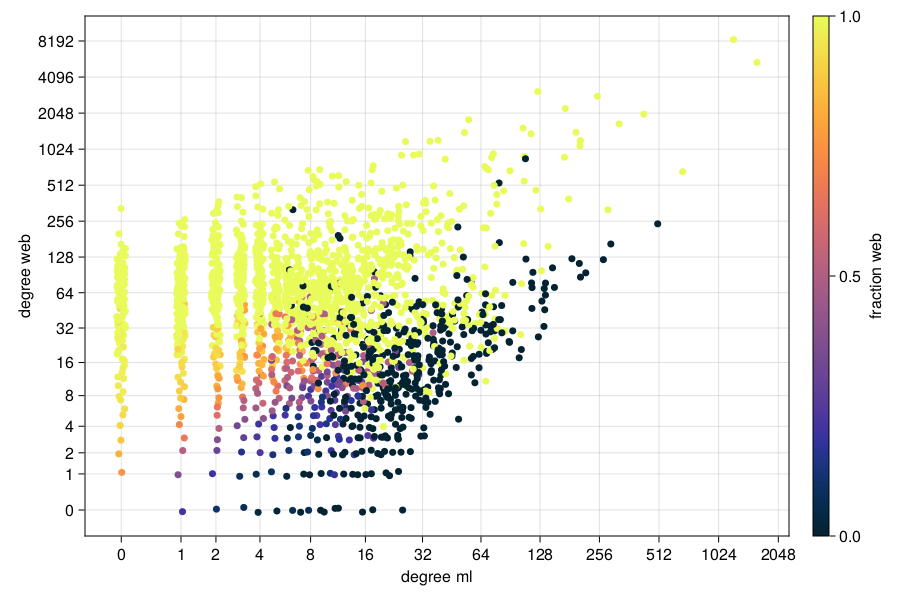

In [21]:
log1pjitter(x) = log1p(x) - 0.05 + rand() / 10

function gen_ticks(maxv)
    max2 = round(Int, log2(maxv))
    tick = [0; 2 .^ (0:max2)]
    return (log1p.(tick), string.(tick))
end

@time begin
    fig = Figure(resolution = (900, 600))
    ax = Axis(fig[1, 1]; xlabel="degree ml", ylabel="degree web",
              xticks=gen_ticks(maximum(gh_data.deg_ml)),
              yticks=gen_ticks(maximum(gh_data.deg_web)))
    sc = scatter!(ax, log1pjitter.(gh_data.deg_ml),
                  log1pjitter.(gh_data.deg_web),
                  color = gh_data.frac,
                  markersize = 10,
                  colormap = :thermal)
    Colorbar(fig[:, end+1], sc, label="fraction web")
    fig
end

  2.629131 seconds (2.87 M allocations: 174.286 MiB, 5.50% gc time, 97.20% compilation time)


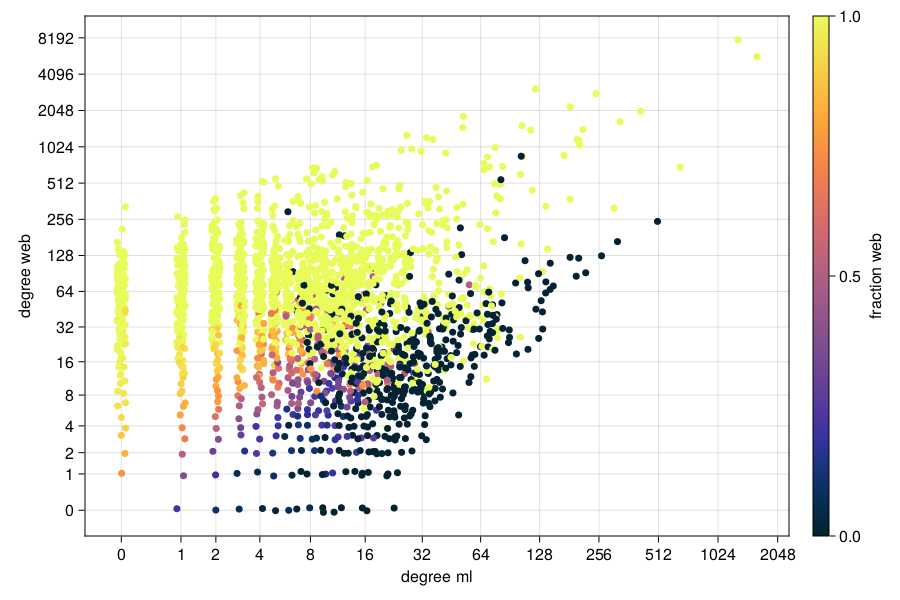

In [22]:
@time begin
    figure = (; resolution = (900, 600))
    axis = (; xticks=gen_ticks(maximum(gh_data.deg_ml)), yticks=gen_ticks(maximum(gh_data.deg_web)))
    colorbar = (; label="fraction web")
    plt = data(gh_data) *
          mapping(:deg_ml => log1pjitter => "degree ml",
                  :deg_web => log1pjitter => "degree web",
                  color = :frac => "fraction web") *
          visual(colormap=:thermal, markersize=10)
    draw(plt; figure, axis, colorbar)
end

1. Plot looks better than in Plots.jl in my opinion.
2. Creating it was relatively straightforward. I had access to everything I needed.
3. AlgebraOfGraphics.jl solution was relatively easy also.

# Lessons learned

1. Functionality is decent: I could do everything I needed and plot quality was very good.
2. The `Figure`-`Axis`-plot split was nice to me. A small downside is that it increases the amount of boilerplate code, but probably this cannot be avoided.
3. I felt that I have fine-grained control over what I am plotting. This is very good.
4. I could find everything I needed to do the plots but I had some problems with documentation:
   * Initially I was not fully clear how to properly set-up the environment.
   * I needed to do a lot of Googling and it often sent me to outdated documentation which gave wrong recommendations (and sometimes I did not spot immediately that the documentation is outdated)
5. If I understand things correctly there are issues with plotting in the terminal. This is an issue in my workflows.
6. It would be still great to improve time to load package and to make plots. For quick-and-dirty interactive plotting they are too slow in my opinion.
7. AlgebraOfGraphics.jl looks very promising, but without help I would not be able to use it in my scenarios.
8. AlgebraOfGraphics.jl is not ggplot2. And this is good. It is better to think about AlgebraOfGraphics.jl as providing extra methods that user can take advantage of, rather than a complete ecosystem on top of Makie.jl.
9. The fact that you can tweak almost everything via introspection is great.